In [164]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

In [165]:
# Load the dataset into a DataFrame
dataset = pd.read_csv('Data_Harga1.csv', delimiter=';')

In [166]:
# Select the relevant columns for features and target variable
features = ['pasar', 'category', 'commodity', 'unit']
target = 'price'

In [167]:
# Extract the features and target variable
X = dataset[features]
y = dataset[target]

In [168]:
# Perform label encoding on the categorical features
label_encoder = LabelEncoder()
for feature in features:
    X[feature] = label_encoder.fit_transform(X[feature])

C:\Users\Wilbert\AppData\Local\Temp\ipykernel_12476\598827087.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = label_encoder.fit_transform(X[feature])
C:\Users\Wilbert\AppData\Local\Temp\ipykernel_12476\598827087.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = label_encoder.fit_transform(X[feature])
C:\Users\Wilbert\AppData\Local\Temp\ipykernel_12476\598827087.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [169]:
# Convert text data to token sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X['pasar'].astype(str))  # Convert values to strings
X_pasar = tokenizer.texts_to_sequences(X['pasar'].astype(str))
X_pasar = pad_sequences(X_pasar)

In [170]:
# Convert numeric feature to standardized values
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

In [171]:
# Combine the processed features
X_combined = np.concatenate((X_pasar, X[features[1:]].values), axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Print the shapes of the data splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (42849, 4)
X_test shape: (10713, 4)
y_train shape: (42849,)
y_test shape: (10713,)


In [172]:
# Define the model architecture
embedding_dim = 200  # Adjust the embedding dimension as needed
vocab_size = len(tokenizer.word_index) + 1

text_input = Input(shape=(X_combined.shape[1],))
embedding_layer = Embedding(vocab_size, embedding_dim)(text_input)

numeric_input = Input(shape=(1,))
reshaped_numeric_input = tf.reshape(numeric_input, (-1, X_combined.shape[1], 1))

concatenated = concatenate([embedding_layer, reshaped_numeric_input])

output = Dense(1, activation='linear')(concatenated)

model = Model(inputs=[text_input, numeric_input], outputs=output)

model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit([X_train, X_train], y_train, epochs=50, batch_size=64)


Epoch 1/50
670/670 [==============================] - 2s 2ms/step - loss: 39938.1523
Epoch 2/50
670/670 [==============================] - 1s 2ms/step - loss: 39539.4492
Epoch 3/50
670/670 [==============================] - 1s 2ms/step - loss: 38822.9844
Epoch 4/50
670/670 [==============================] - 1s 2ms/step - loss: 37845.5469
Epoch 5/50
670/670 [==============================] - 1s 2ms/step - loss: 36643.0117
Epoch 6/50
670/670 [==============================] - 1s 2ms/step - loss: 35237.2617
Epoch 7/50
670/670 [==============================] - 1s 2ms/step - loss: 33641.8516
Epoch 8/50
670/670 [==============================] - 1s 2ms/step - loss: 31875.9512
Epoch 9/50
670/670 [==============================] - 1s 2ms/step - loss: 30075.0117
Epoch 10/50
670/670 [==============================] - 1s 2ms/step - loss: 28438.9180
Epoch 11/50
670/670 [==============================] - 1s 2ms/step - loss: 27042.6992
Epoch 12/50
670/670 [==============================] - 1s 2ms/s

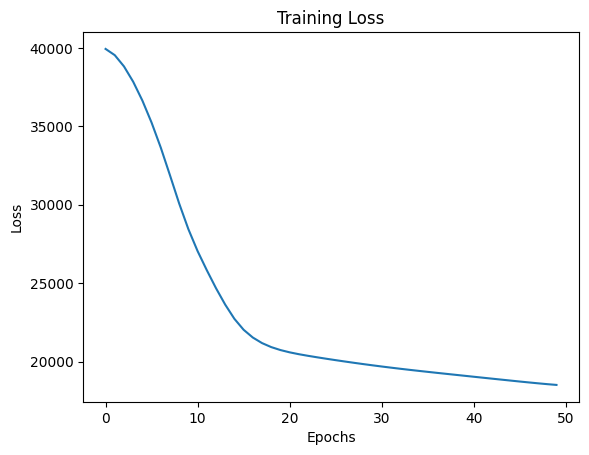

In [175]:
# Plot Loss Training
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
